In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import nltk
import pickle
import pyLDAvis.sklearn
from collections import Counter
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from lxml import html
import string
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim 
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\vinay\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
flipkarts = []

def get_soup(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    return soup

def get_reviews(soup):
    flipkarts_a = []
    containers = soup.findAll("div", {'class': '_2wrUUKlw _3hFEdNs8'})
    for i in containers:
        ratings = i.select_one('span.ui_bubble_rating')['class']
        ratings = ratings[1].split('_')[-1]
        #print(ratings)
        re = {
        'rating' : ratings,
        'review' : i.find("q", {"class": "IRsGHoPm"}).text,
        }
        flipkarts_a.append(re)
    return flipkarts_a

for x in range(1,660,5):
    url = 'https://www.tripadvisor.in/Hotel_Review-g297628-d13943346-Reviews-or'+str(x)+'-Sheraton_Grand_Bengaluru_Whitefield_Hotel_Convention_Center-Bengaluru_Bangalore_.html#REVIEWS'
    soup = get_soup(url)
    #print(f'Getting page: {x}')
    
    flipkarts = flipkarts + get_reviews(soup)
   # print(len(flipkarts))
    if not soup.find('li', {'class': 'a-disabled a-last'}):
        pass
    else:
        break
df = pd.DataFrame(flipkarts)
print(df.shape)
df.head()

(660, 2)


,rating,review
0,50,Extremely comfortable stay post pandemic. Pers...
1,50,We were at the hotel for a night stay over the...
2,50,Excellent hospitality and facilities! Highly c...
3,40,The rooms are really good and equipped with al...
4,50,Stayed at the Sheraton property at Whitefield ...


In [3]:
df.groupby('rating').count()

,review
rating,
10,4
30,1
40,23
50,632


In [4]:
df.to_csv('sheraton.csv')

In [5]:
with open('sheraton.csv',encoding='utf-8') as f:
    bb_df = pd.read_csv(f)
f.close()
bb_df.drop('Unnamed: 0', axis=1, inplace=True)
bb_df

,rating,review
0,50,Extremely comfortable stay post pandemic. Pers...
1,50,We were at the hotel for a night stay over the...
2,50,Excellent hospitality and facilities! Highly c...
3,40,The rooms are really good and equipped with al...
4,50,Stayed at the Sheraton property at Whitefield ...
...,...,...
655,50,I visited the place for the first time to cele...
656,50,"Near to the city and public transport, friendl..."
657,50,"Being Bangalore one of my fav city,I always en..."
658,50,"Arup kumar shaw, Maruti nanda and Gaurav bhat...."


In [6]:
#tokenizing the reviews
bb_df['tokenized'] = bb_df['review'].apply(word_tokenize)
#converting all to lowercase
bb_df['lower'] = bb_df['tokenized'].apply(lambda x: [word.lower() for word in x])
#removing punctuations
punc = string.punctuation
bb_df['no_punc'] = bb_df['lower'].apply(lambda x: [word for word in x if word not in punc])
#removing stop words
stop_words = set(stopwords.words('english'))
stop_words.update(['.',';'])
bb_df['stopwords_removed'] = bb_df['no_punc'].apply(lambda x: [word for word in x if word not in stop_words])
bb_df.head()

,rating,review,tokenized,lower,no_punc,stopwords_removed
0,50,Extremely comfortable stay post pandemic. Pers...,"[Extremely, comfortable, stay, post, pandemic,...","[extremely, comfortable, stay, post, pandemic,...","[extremely, comfortable, stay, post, pandemic,...","[extremely, comfortable, stay, post, pandemic,..."
1,50,We were at the hotel for a night stay over the...,"[We, were, at, the, hotel, for, a, night, stay...","[we, were, at, the, hotel, for, a, night, stay...","[we, were, at, the, hotel, for, a, night, stay...","[hotel, night, stay, weekend, thoroughly, love..."
2,50,Excellent hospitality and facilities! Highly c...,"[Excellent, hospitality, and, facilities, !, H...","[excellent, hospitality, and, facilities, !, h...","[excellent, hospitality, and, facilities, high...","[excellent, hospitality, facilities, highly, c..."
3,40,The rooms are really good and equipped with al...,"[The, rooms, are, really, good, and, equipped,...","[the, rooms, are, really, good, and, equipped,...","[the, rooms, are, really, good, and, equipped,...","[rooms, really, good, equipped, one, expect, 5..."
4,50,Stayed at the Sheraton property at Whitefield ...,"[Stayed, at, the, Sheraton, property, at, Whit...","[stayed, at, the, sheraton, property, at, whit...","[stayed, at, the, sheraton, property, at, whit...","[stayed, sheraton, property, whitefield, banga..."


In [7]:
#lemmitization
#first apply parts of speech tags
bb_df['pos_tags'] = bb_df['stopwords_removed'].apply(nltk.tag.pos_tag)
bb_df.head()

,rating,review,tokenized,lower,no_punc,stopwords_removed,pos_tags
0,50,Extremely comfortable stay post pandemic. Pers...,"[Extremely, comfortable, stay, post, pandemic,...","[extremely, comfortable, stay, post, pandemic,...","[extremely, comfortable, stay, post, pandemic,...","[extremely, comfortable, stay, post, pandemic,...","[(extremely, RB), (comfortable, JJ), (stay, NN..."
1,50,We were at the hotel for a night stay over the...,"[We, were, at, the, hotel, for, a, night, stay...","[we, were, at, the, hotel, for, a, night, stay...","[we, were, at, the, hotel, for, a, night, stay...","[hotel, night, stay, weekend, thoroughly, love...","[(hotel, NN), (night, NN), (stay, VB), (weeken..."
2,50,Excellent hospitality and facilities! Highly c...,"[Excellent, hospitality, and, facilities, !, H...","[excellent, hospitality, and, facilities, !, h...","[excellent, hospitality, and, facilities, high...","[excellent, hospitality, facilities, highly, c...","[(excellent, JJ), (hospitality, NN), (faciliti..."
3,40,The rooms are really good and equipped with al...,"[The, rooms, are, really, good, and, equipped,...","[the, rooms, are, really, good, and, equipped,...","[the, rooms, are, really, good, and, equipped,...","[rooms, really, good, equipped, one, expect, 5...","[(rooms, NNS), (really, RB), (good, JJ), (equi..."
4,50,Stayed at the Sheraton property at Whitefield ...,"[Stayed, at, the, Sheraton, property, at, Whit...","[stayed, at, the, sheraton, property, at, whit...","[stayed, at, the, sheraton, property, at, whit...","[stayed, sheraton, property, whitefield, banga...","[(stayed, VBN), (sheraton, NN), (property, NN)..."


In [8]:
#lemmitizing only certain parts of speech using the custom function
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
bb_df['wordnet_pos'] = bb_df['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
wnl = WordNetLemmatizer()
bb_df['lemmatized'] = bb_df['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
bb_df.head()

,rating,review,tokenized,lower,no_punc,stopwords_removed,pos_tags,wordnet_pos,lemmatized
0,50,Extremely comfortable stay post pandemic. Pers...,"[Extremely, comfortable, stay, post, pandemic,...","[extremely, comfortable, stay, post, pandemic,...","[extremely, comfortable, stay, post, pandemic,...","[extremely, comfortable, stay, post, pandemic,...","[(extremely, RB), (comfortable, JJ), (stay, NN...","[(extremely, r), (comfortable, a), (stay, n), ...","[extremely, comfortable, stay, post, pandemic,..."
1,50,We were at the hotel for a night stay over the...,"[We, were, at, the, hotel, for, a, night, stay...","[we, were, at, the, hotel, for, a, night, stay...","[we, were, at, the, hotel, for, a, night, stay...","[hotel, night, stay, weekend, thoroughly, love...","[(hotel, NN), (night, NN), (stay, VB), (weeken...","[(hotel, n), (night, n), (stay, v), (weekend, ...","[hotel, night, stay, weekend, thoroughly, love..."
2,50,Excellent hospitality and facilities! Highly c...,"[Excellent, hospitality, and, facilities, !, H...","[excellent, hospitality, and, facilities, !, h...","[excellent, hospitality, and, facilities, high...","[excellent, hospitality, facilities, highly, c...","[(excellent, JJ), (hospitality, NN), (faciliti...","[(excellent, a), (hospitality, n), (facilities...","[excellent, hospitality, facility, highly, cou..."
3,40,The rooms are really good and equipped with al...,"[The, rooms, are, really, good, and, equipped,...","[the, rooms, are, really, good, and, equipped,...","[the, rooms, are, really, good, and, equipped,...","[rooms, really, good, equipped, one, expect, 5...","[(rooms, NNS), (really, RB), (good, JJ), (equi...","[(rooms, n), (really, r), (good, a), (equipped...","[room, really, good, equip, one, expect, 5, st..."
4,50,Stayed at the Sheraton property at Whitefield ...,"[Stayed, at, the, Sheraton, property, at, Whit...","[stayed, at, the, sheraton, property, at, whit...","[stayed, at, the, sheraton, property, at, whit...","[stayed, sheraton, property, whitefield, banga...","[(stayed, VBN), (sheraton, NN), (property, NN)...","[(stayed, v), (sheraton, n), (property, n), (w...","[stay, sheraton, property, whitefield, bangalo..."


****Sentiment analysis using text blob****

In [9]:
bb_df_new = bb_df[['rating','lemmatized']]
#forming a string in order to determine the sentiment of review using textblob
bb_df_new['lemma_str'] = [' '.join(map(str,l)) for l in bb_df_new['lemmatized']]
bb_df_new

C:\Users\vinay\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,rating,lemmatized,lemma_str
0,50,"[extremely, comfortable, stay, post, pandemic,...",extremely comfortable stay post pandemic perso...
1,50,"[hotel, night, stay, weekend, thoroughly, love...",hotel night stay weekend thoroughly love stay ...
2,50,"[excellent, hospitality, facility, highly, cou...",excellent hospitality facility highly courteou...
3,40,"[room, really, good, equip, one, expect, 5, st...",room really good equip one expect 5 star hotel...
4,50,"[stay, sheraton, property, whitefield, bangalo...",stay sheraton property whitefield bangalore 3r...
...,...,...,...
655,50,"[visited, place, first, time, celebrate, frien...",visited place first time celebrate friend birt...
656,50,"[near, city, public, transport, friendly, staf...",near city public transport friendly staff hote...
657,50,"[bangalore, one, fav, city, always, enjoy, com...",bangalore one fav city always enjoy come here....
658,50,"[arup, kumar, shaw, maruti, nanda, gaurav, bha...",arup kumar shaw maruti nanda gaurav bhat ... e...


In [10]:
bb_df_new['sentiment'] = bb_df_new['lemma_str'].apply(lambda x: TextBlob(x).sentiment.polarity)
bb_df_new.head()

C:\Users\vinay\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,rating,lemmatized,lemma_str,sentiment
0,50,"[extremely, comfortable, stay, post, pandemic,...",extremely comfortable stay post pandemic perso...,0.400000
1,50,"[hotel, night, stay, weekend, thoroughly, love...",hotel night stay weekend thoroughly love stay ...,0.542857
2,50,"[excellent, hospitality, facility, highly, cou...",excellent hospitality facility highly courteou...,0.550000
3,40,"[room, really, good, equip, one, expect, 5, st...",room really good equip one expect 5 star hotel...,0.420833
4,50,"[stay, sheraton, property, whitefield, bangalo...",stay sheraton property whitefield bangalore 3r...,0.400000


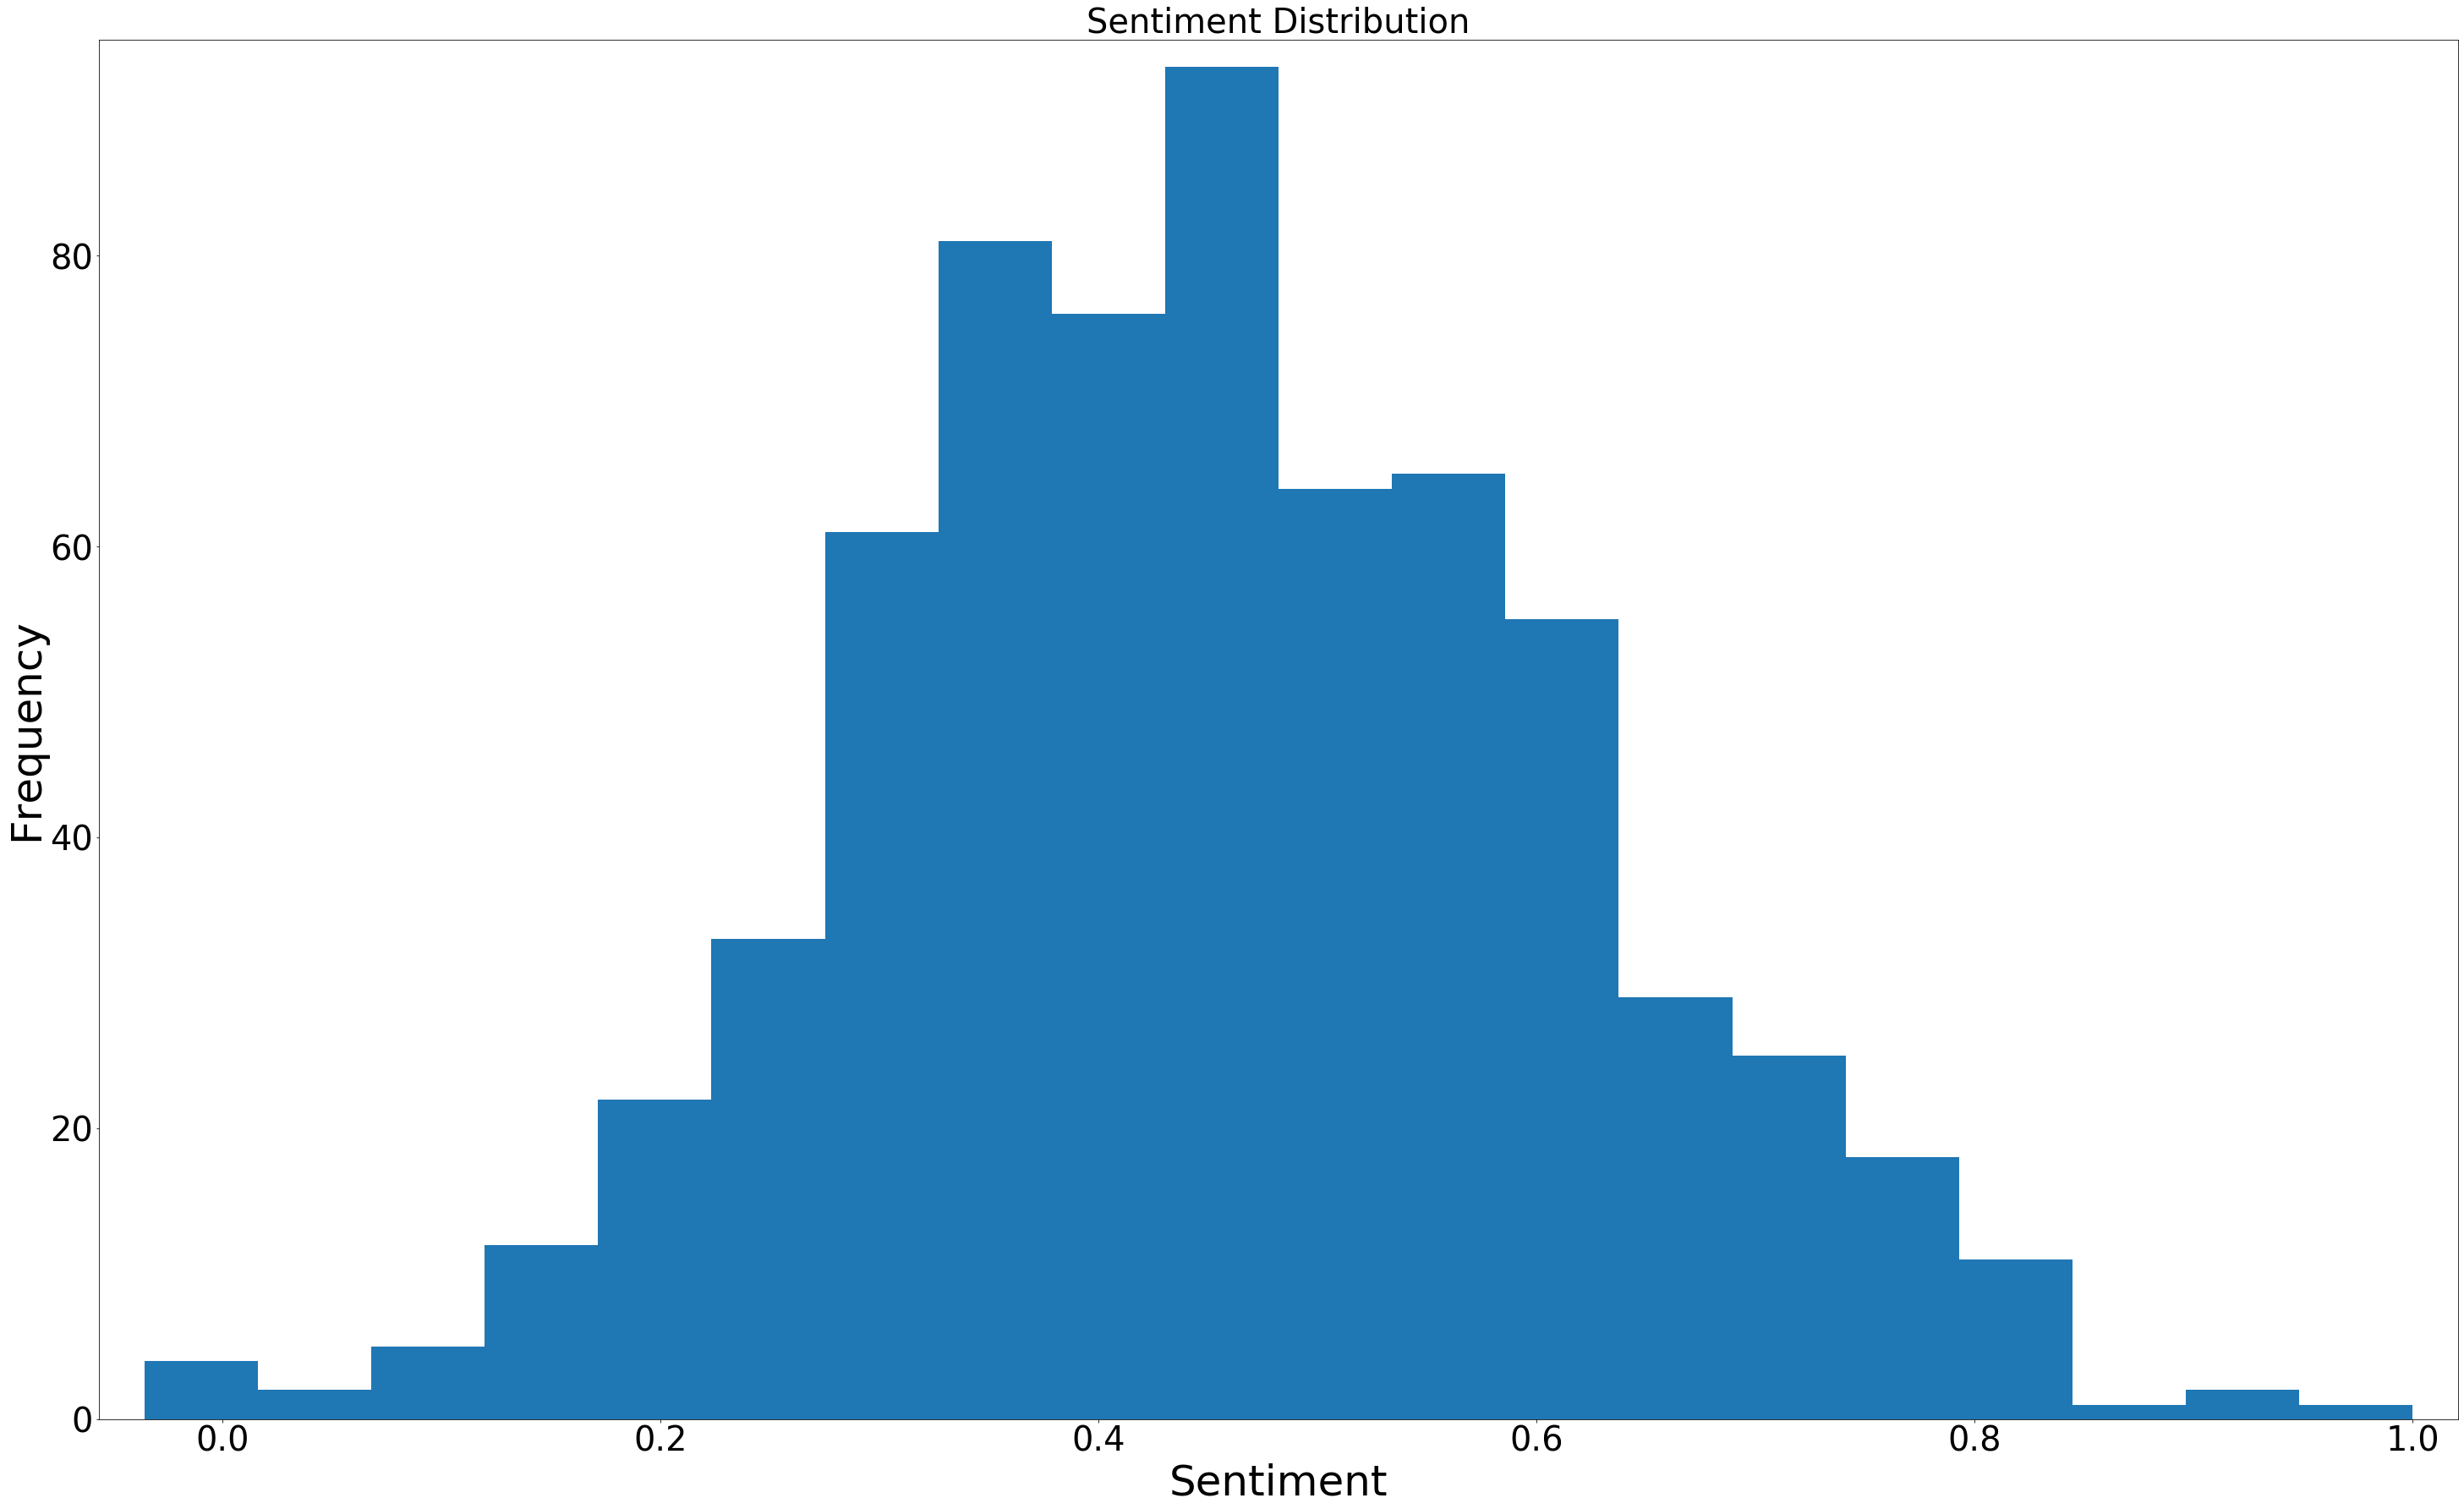

In [11]:
#sentiment distribution
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(bb_df_new['sentiment'], bins=20)
plt.title('Sentiment Distribution', fontsize=40)
plt.show()

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

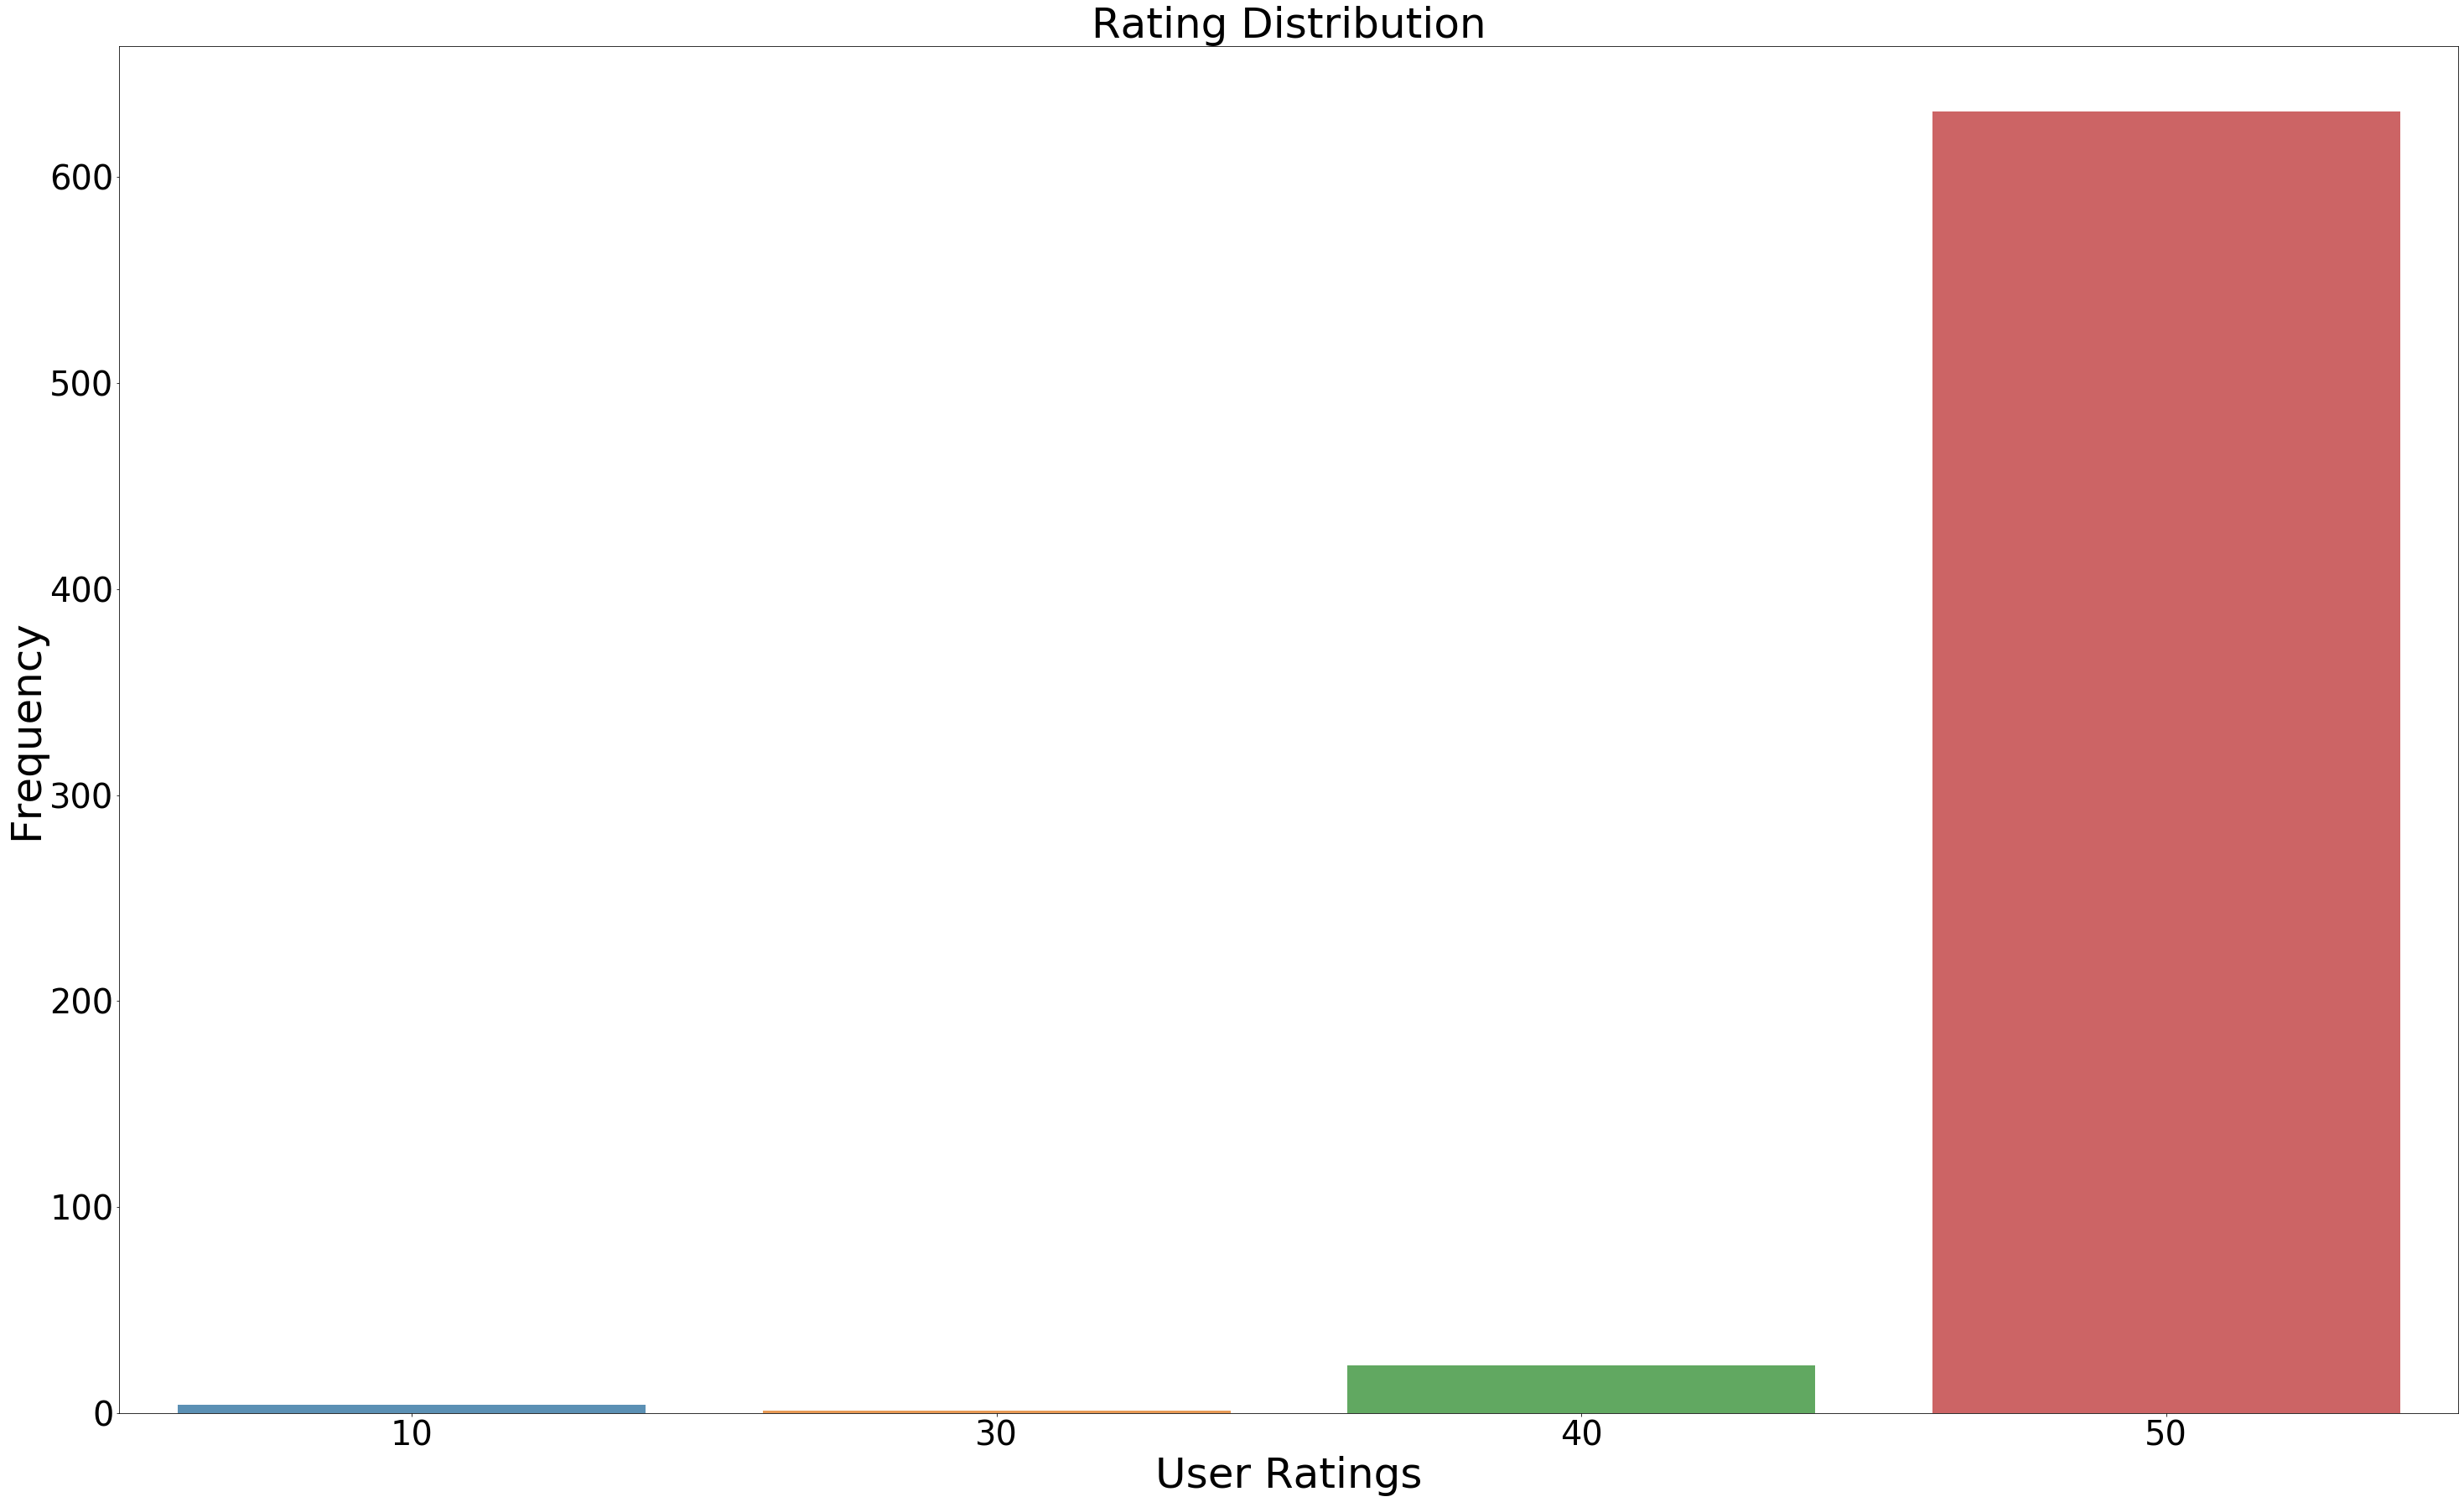

In [12]:
#rating distribution
x_rating = bb_df_new.rating.value_counts()
y_rating = x_rating.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(x_rating.index, x_rating.values, alpha=0.8)
plt.title("Rating Distribution", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('User Ratings', fontsize=50)
plt.xticks(fontsize=40)

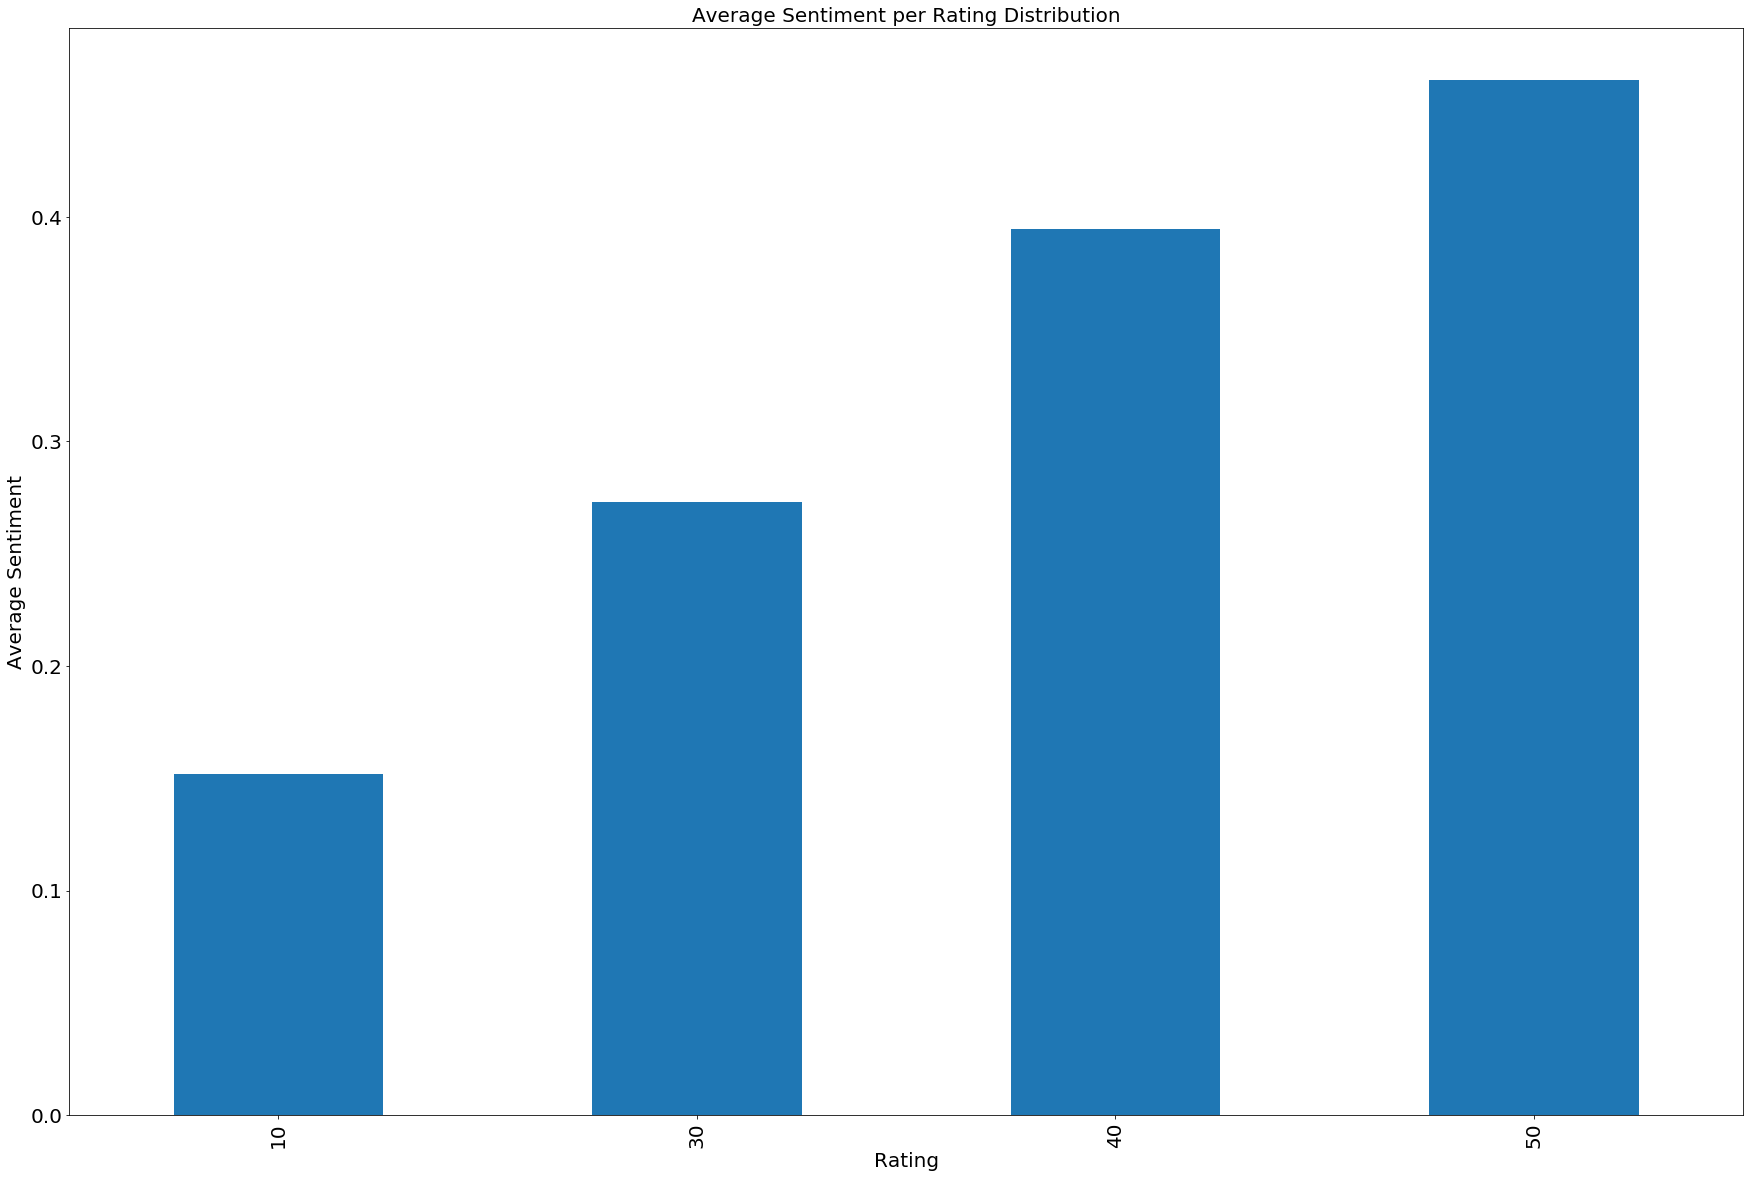

In [13]:
#sentiment and rating distribution
polarity_avg = bb_df_new.groupby('rating')['sentiment'].mean().plot(kind='bar', figsize=(30,20))
plt.xlabel('Rating', fontsize=20)
plt.ylabel('Average Sentiment', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Average Sentiment per Rating Distribution', fontsize=20)
plt.show()

In [14]:
review_type = []
for i in bb_df_new['rating']:
    if i == 10:
        t = 'Negative'
    elif i == 20:
        t = 'Negative'
    elif i == 30:
        t = 'Negative'
    else:
        t = 'Positive'
    
    review_type.append(t)

In [15]:
bb_df_new['review_type'] = review_type
bb_df_new

C:\Users\vinay\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,rating,lemmatized,lemma_str,sentiment,review_type
0,50,"[extremely, comfortable, stay, post, pandemic,...",extremely comfortable stay post pandemic perso...,0.400000,Positive
1,50,"[hotel, night, stay, weekend, thoroughly, love...",hotel night stay weekend thoroughly love stay ...,0.542857,Positive
2,50,"[excellent, hospitality, facility, highly, cou...",excellent hospitality facility highly courteou...,0.550000,Positive
3,40,"[room, really, good, equip, one, expect, 5, st...",room really good equip one expect 5 star hotel...,0.420833,Positive
4,50,"[stay, sheraton, property, whitefield, bangalo...",stay sheraton property whitefield bangalore 3r...,0.400000,Positive
...,...,...,...,...,...
655,50,"[visited, place, first, time, celebrate, frien...",visited place first time celebrate friend birt...,0.625000,Positive
656,50,"[near, city, public, transport, friendly, staf...",near city public transport friendly staff hote...,0.317708,Positive
657,50,"[bangalore, one, fav, city, always, enjoy, com...",bangalore one fav city always enjoy come here....,0.384524,Positive
658,50,"[arup, kumar, shaw, maruti, nanda, gaurav, bha...",arup kumar shaw maruti nanda gaurav bhat ... e...,0.450000,Positive


In [16]:
bb_negative = bb_df_new[bb_df_new['review_type']=='Negative']
bb_positive = bb_df_new[bb_df_new['review_type']=='Positive']
bb_positive

,rating,lemmatized,lemma_str,sentiment,review_type
0,50,"[extremely, comfortable, stay, post, pandemic,...",extremely comfortable stay post pandemic perso...,0.400000,Positive
1,50,"[hotel, night, stay, weekend, thoroughly, love...",hotel night stay weekend thoroughly love stay ...,0.542857,Positive
2,50,"[excellent, hospitality, facility, highly, cou...",excellent hospitality facility highly courteou...,0.550000,Positive
3,40,"[room, really, good, equip, one, expect, 5, st...",room really good equip one expect 5 star hotel...,0.420833,Positive
4,50,"[stay, sheraton, property, whitefield, bangalo...",stay sheraton property whitefield bangalore 3r...,0.400000,Positive
...,...,...,...,...,...
655,50,"[visited, place, first, time, celebrate, frien...",visited place first time celebrate friend birt...,0.625000,Positive
656,50,"[near, city, public, transport, friendly, staf...",near city public transport friendly staff hote...,0.317708,Positive
657,50,"[bangalore, one, fav, city, always, enjoy, com...",bangalore one fav city always enjoy come here....,0.384524,Positive
658,50,"[arup, kumar, shaw, maruti, nanda, gaurav, bha...",arup kumar shaw maruti nanda gaurav bhat ... e...,0.450000,Positive


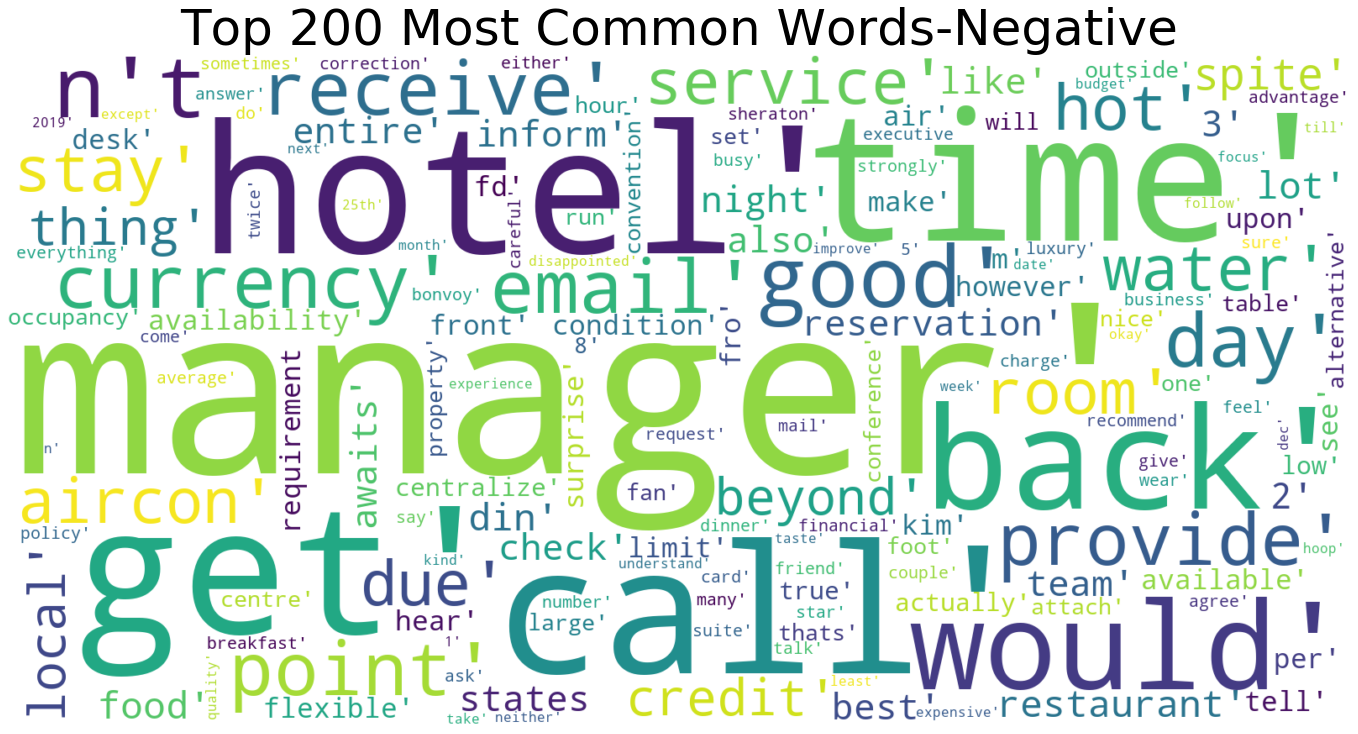

In [17]:
#word cloud for negative words

neg_words = bb_negative['lemmatized']
allwords_neg = []
for wordlist in neg_words:
    allwords_neg += wordlist
mostcommon_neg = FreqDist(allwords_neg).most_common(200)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon_neg))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 200 Most Common Words-Negative', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

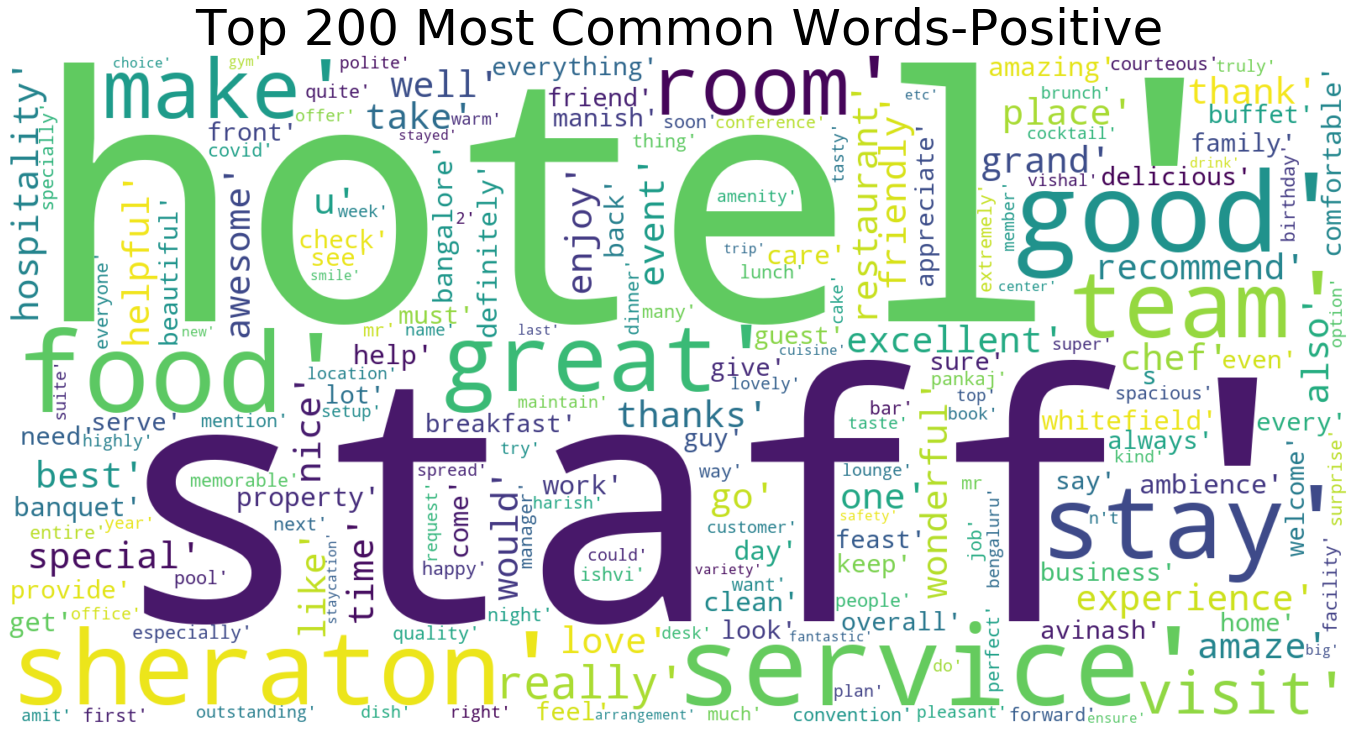

In [19]:
#word cloud for positive reviews

pos_words = bb_positive['lemmatized']
allwords_pos = []
for wordlist in pos_words:
    allwords_pos += wordlist
mostcommon_pos = FreqDist(allwords_pos).most_common(200)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon_pos))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 200 Most Common Words-Positive', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

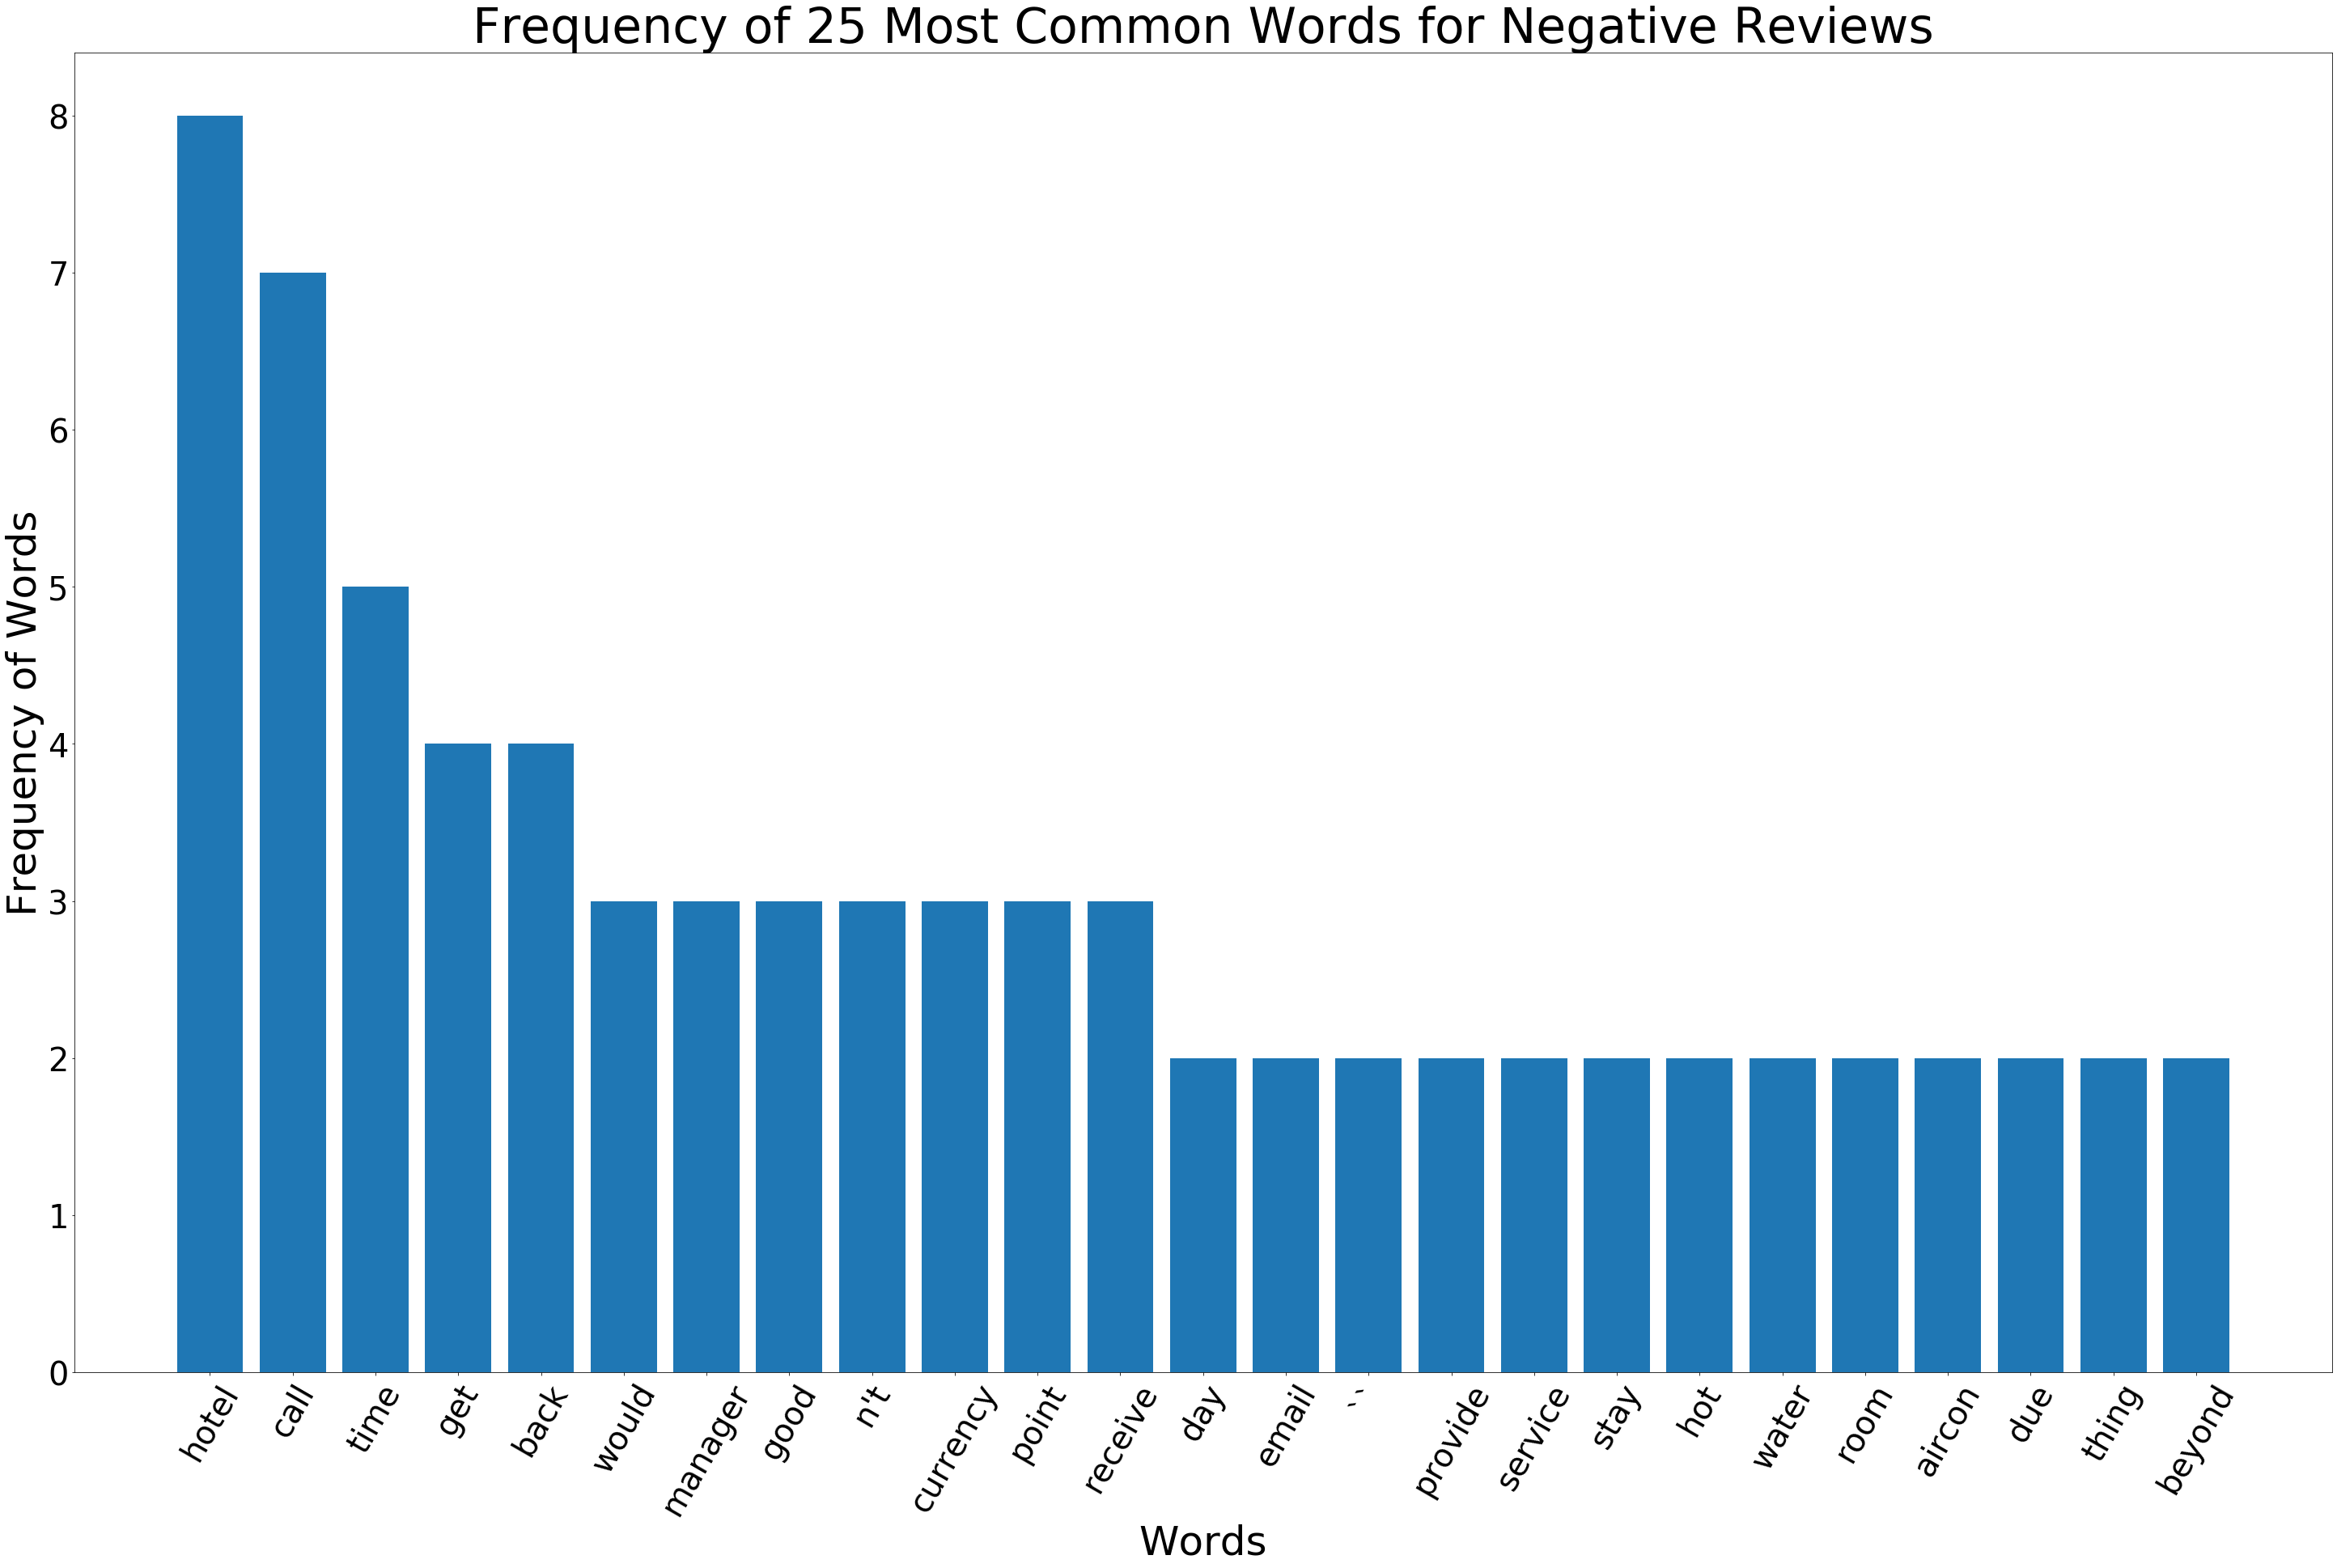

In [20]:
group_by = bb_df_new.groupby('review_type')['lemma_str'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))
group_by_neg = group_by.iloc[0]
words_neg = list(zip(*group_by_neg))[0]
freq_neg = list(zip(*group_by_neg))[1]
plt.figure(figsize=(50,30))
plt.bar(words_neg, freq_neg)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Negative Reviews', fontsize=60)
plt.show()

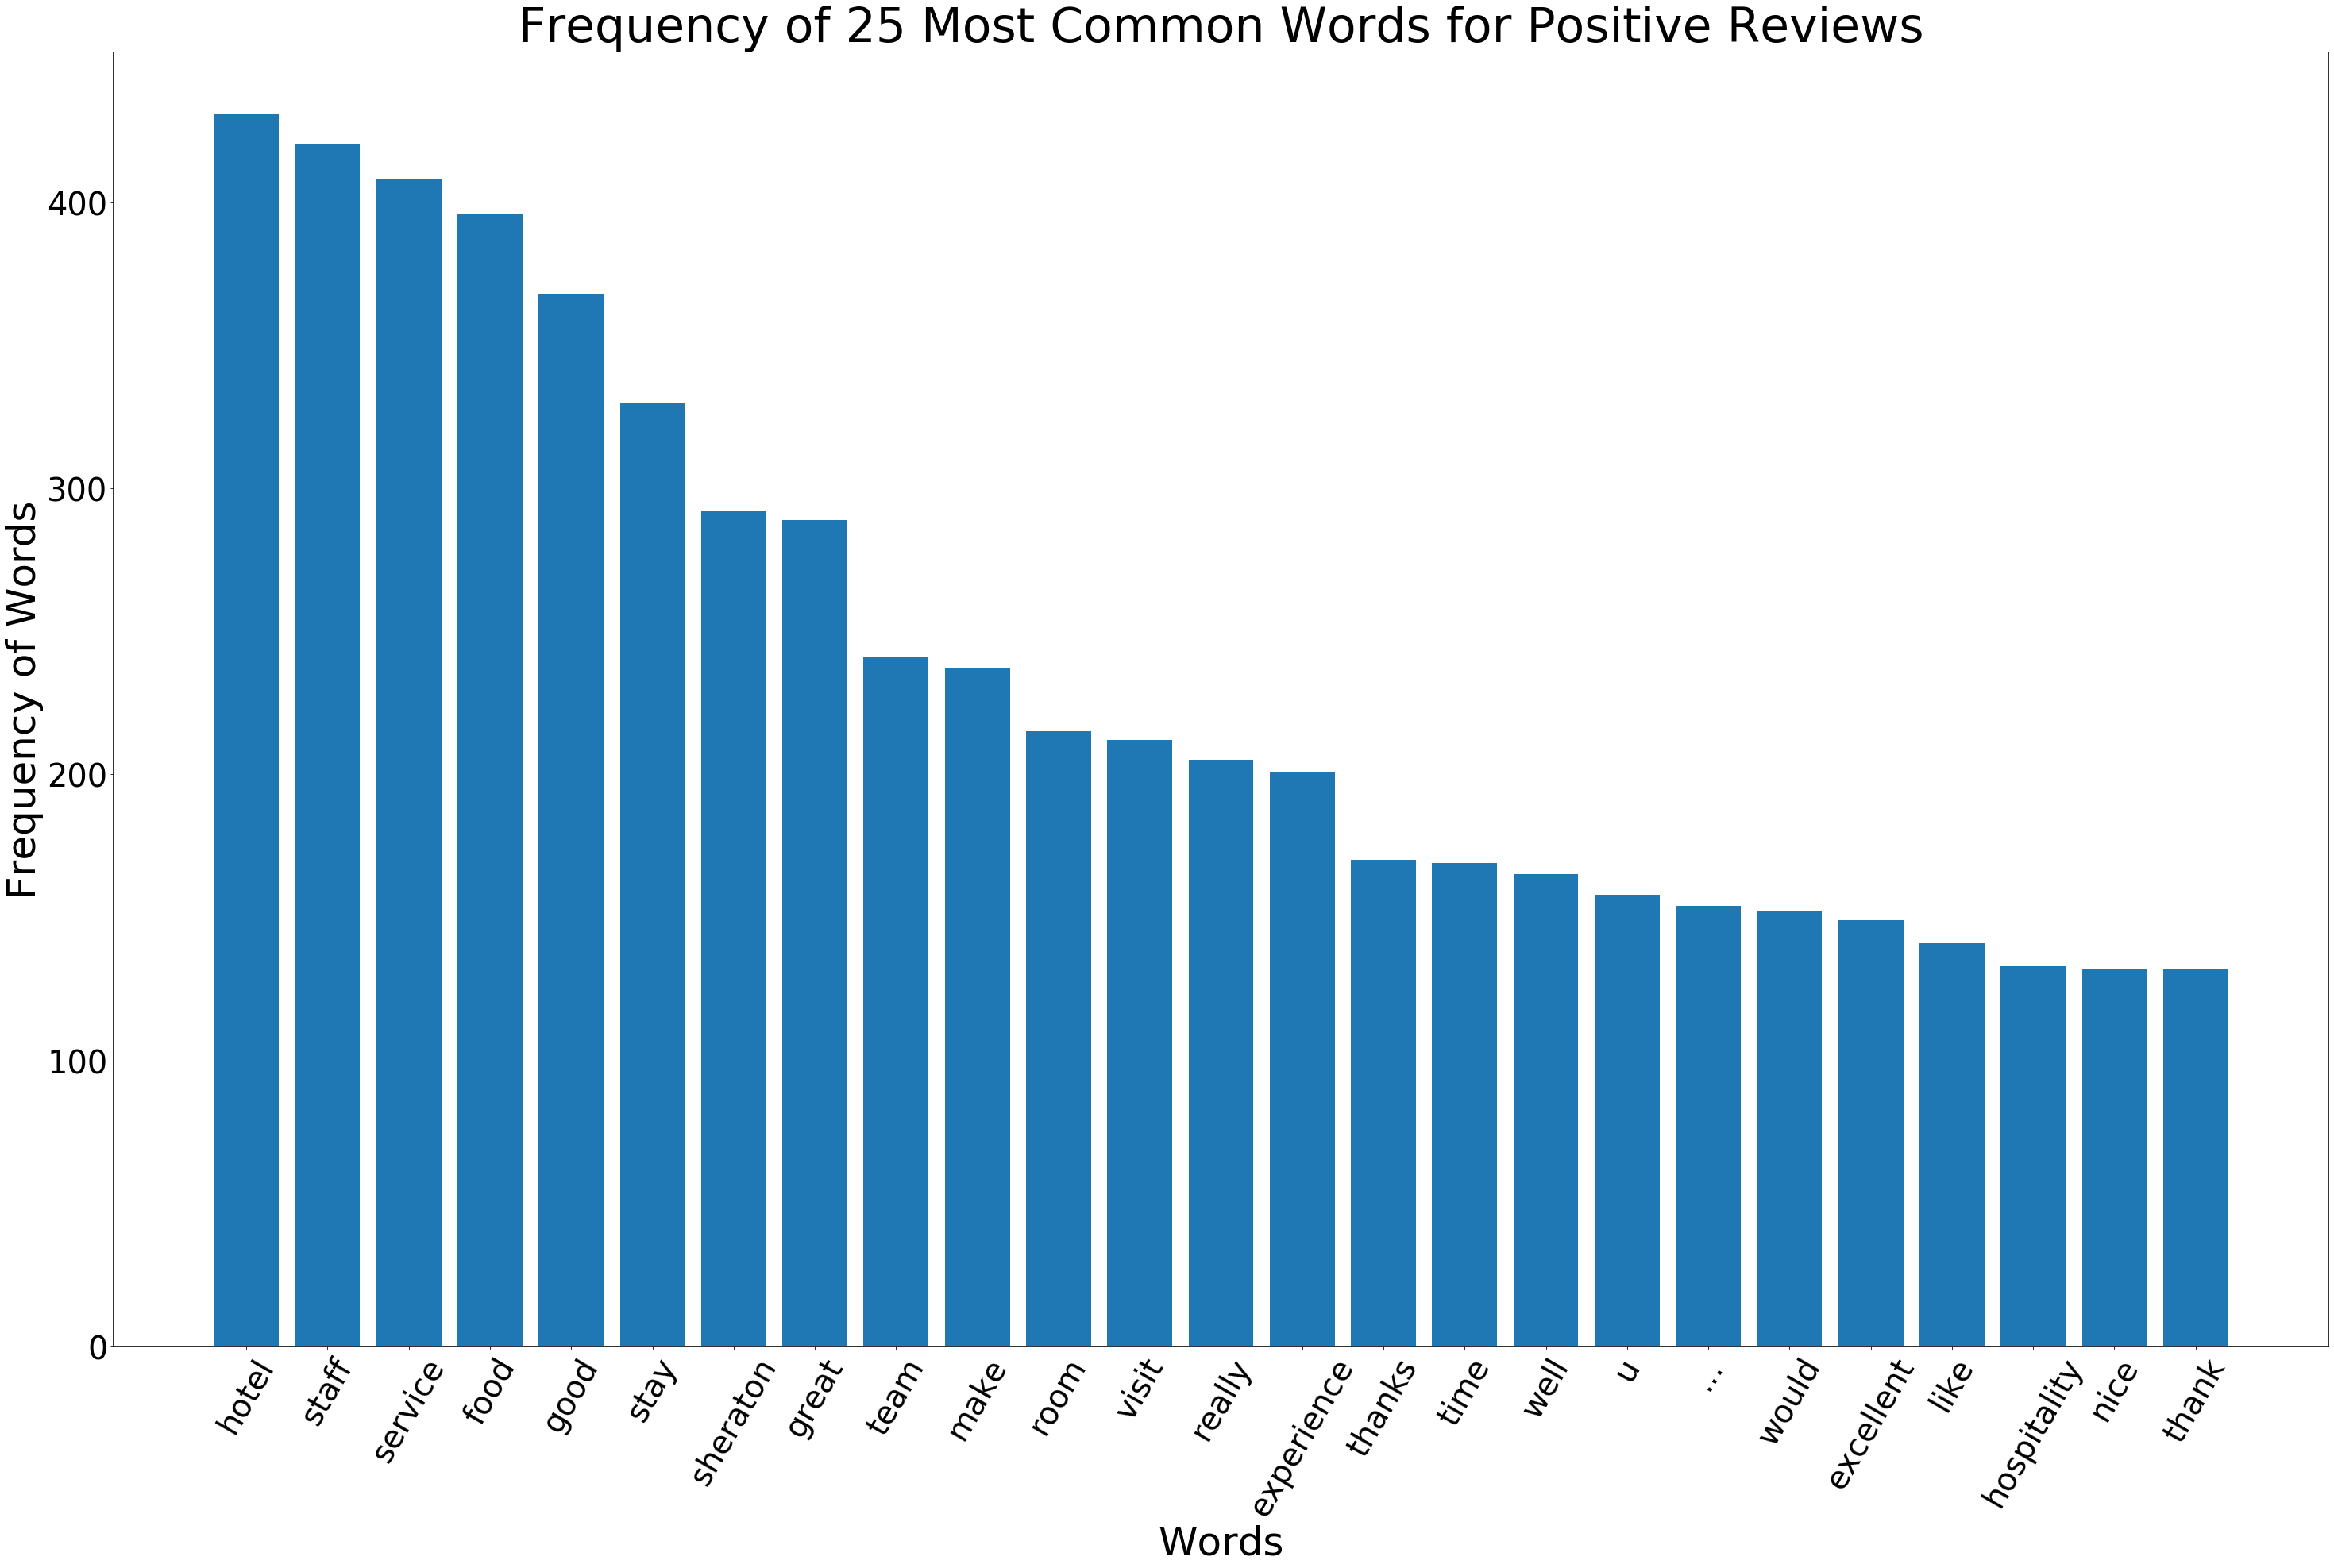

In [21]:
group_by_pos = group_by.iloc[1]
words_pos = list(zip(*group_by_pos))[0]
freq_pos = list(zip(*group_by_pos))[1]
plt.figure(figsize=(50,30))
plt.bar(words_pos, freq_pos)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Positive Reviews', fontsize=60)
plt.show()

****TOPIC MODELLING****

****For negative reviews****

In [35]:
from gensim import corpora
dictionary_neg = corpora.Dictionary(bb_negative['lemmatized'])
corpus = [dictionary_neg.doc2bow(text) for text in bb_negative['lemmatized']]
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary_neg.save('dictionary_neg.gensim')
ldamodel_neg = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word = dictionary_neg, passes=20)
ldamodel_neg.save('neg_model.gensim')
topics = ldamodel_neg.print_topics(num_words=8)
for topic in topics:
    print(topic)

(0, '0.071*"hotel" + 0.054*"currency" + 0.037*"spite" + 0.037*"local" + 0.020*"due" + 0.020*"recommend" + 0.020*"credit" + 0.020*"answer"')
(1, '0.028*"get" + 0.028*"call" + 0.028*"hotel" + 0.028*"would" + 0.019*"back" + 0.019*"day" + 0.019*"aircon" + 0.019*"provide"')
(2, '0.045*"call" + 0.034*"point" + 0.034*"receive" + 0.023*"time" + 0.023*"manager" + 0.023*"restaurant" + 0.023*"din" + 0.023*"back"')
(3, '0.040*"time" + 0.040*"lot" + 0.040*"food" + 0.040*"good" + 0.022*"service" + 0.022*"focus" + 0.022*"except" + 0.022*"improve"')
(4, '0.040*"n\'t" + 0.022*"good" + 0.022*"thing" + 0.022*"beyond" + 0.022*"stay" + 0.022*"star" + 0.022*"feel" + 0.022*"centre"')


In [33]:
dictionary_neg = gensim.corpora.Dictionary.load('dictionary_neg.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
ldaneg = gensim.models.ldamodel.LdaModel.load('neg_model.gensim')
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(ldaneg, corpus, dictionary_neg, sort_topics=False)
pyLDAvis.display(lda_display)

***FOR POSITIVE REVIEWS****

In [34]:
from gensim import corpora
dictionary_pos = corpora.Dictionary(bb_positive['lemmatized'])
corpus_pos = [dictionary_pos.doc2bow(text) for text in bb_positive['lemmatized']]
import pickle
pickle.dump(corpus_pos, open('corpus_pos.pkl', 'wb'))
dictionary_pos.save('dictionary_pos.gensim')
ldamodel_pos = gensim.models.ldamodel.LdaModel(corpus_pos, num_topics=10, id2word = dictionary_pos, passes=20)
ldamodel_pos.save('pos_model.gensim')
topics_pos = ldamodel_pos.print_topics(num_words=8)
for topic in topics_pos:
    print(topic)

(0, '0.023*"stay" + 0.018*"staff" + 0.017*"hotel" + 0.017*"great" + 0.015*"sheraton" + 0.015*"make" + 0.014*"service" + 0.013*"experience"')
(1, '0.026*"..." + 0.020*"hotel" + 0.016*"stay" + 0.015*"staff" + 0.015*"service" + 0.012*"visit" + 0.012*"would" + 0.011*"food"')
(2, '0.016*"staff" + 0.016*"hotel" + 0.014*"food" + 0.011*"good" + 0.011*"room" + 0.009*"great" + 0.009*"visit" + 0.009*"restaurant"')
(3, '0.024*"..." + 0.021*"really" + 0.021*"service" + 0.019*"good" + 0.017*"thanks" + 0.017*"staff" + 0.014*"great" + 0.014*"visit"')
(4, '0.014*"sheraton" + 0.013*"stay" + 0.012*"hotel" + 0.011*"best" + 0.009*"make" + 0.009*"staff" + 0.009*"thank" + 0.009*"hospitality"')
(5, '0.021*"hotel" + 0.020*"staff" + 0.017*"service" + 0.016*"stay" + 0.015*"food" + 0.011*"good" + 0.010*"sheraton" + 0.009*"like"')
(6, '0.017*"food" + 0.016*"staff" + 0.014*"service" + 0.013*"good" + 0.011*"great" + 0.010*"hotel" + 0.009*"restaurant" + 0.008*"place"')
(7, '0.022*"food" + 0.018*"good" + 0.018*"servic

In [ ]:
dictionary_pos = gensim.corpora.Dictionary.load('dictionary_pos.gensim')
corpus_pos = pickle.load(open('corpus_pos.pkl', 'rb'))
ldapos = gensim.models.ldamodel.LdaModel.load('pos_model.gensim')
import pyLDAvis.gensim
lda_display_pos = pyLDAvis.gensim.prepare(ldapos, corpus, dictionary_pos, sort_topics=False)
pyLDAvis.display(lda_display_pos)